In [1]:
import numpy as np
import pandas as pd
import utils.sulfur.constant as const

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer
from oasis.functions import deconvolve

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

def search_shock_cells(df, context_data, animal_name, context_name, std_product_element=1.0):
    shuffled_count = 1000
    threshold = 0.05
    
    upper_event_rate_cells_1 = []
    upper_event_rate_cells_2 = []
    upper_event_rate_cells_3 = []
    upper_event_rate_cells_all = []
    
    for cell_name, items in context_data.data_frame.iteritems():
        if not context_data.is_engram(cell_name):
            continue
            
        items = items.astype(float)
        if items.isnull().all() or (items == 0).all():
            continue
        
        items = items.to_numpy()
        
        _c, spikes, _b, _g, _lam = deconvolve(items, g=(None, None), penalty=1)
        
        real_shock_value_1 = spikes[80:100]
        real_shock_event_rate_1 = len(real_shock_value_1[real_shock_value_1 >= threshold]) / 2.0
        
        real_shock_value_2 = spikes[980:1000]
        real_shock_event_rate_2 = len(real_shock_value_2[real_shock_value_2 >= threshold]) / 2.0
        
        real_shock_value_3 = spikes[1880:1900]
        real_shock_event_rate_3 = len(real_shock_value_3[real_shock_value_3 >= threshold]) / 2.0
        
        shuffle_event_rates = np.array([])
        for _ in range(shuffled_count):
            #random_time = np.random.randint(0, len(items), size=20)
            #shuffle_value = spikes[random_time]
            #shuffled_event_rate = len(shuffle_value[shuffle_value >= threshold]) / 2.0
            #shuffle_event_rates = np.append(shuffle_event_rates, shuffled_event_rate)
            
            random_time = np.random.randint(0, len(items), size=len(items))
            shuffled_items = items[random_time]
            
            _c, spikes, _b, _g, _lam = deconvolve(shuffled_items, g=(None, None), penalty=1)
            shuffled_shock_value_1 = spikes[80:100]
            shuffled_event_rate_1 = len(shuffled_shock_value_1[shuffled_shock_value_1 >= threshold]) / 2.0
            
            shuffled_shock_value_2 = spikes[980:1000]
            shuffled_event_rate_2 = len(shuffled_shock_value_2[shuffled_shock_value_2 >= threshold]) / 2.0
            
            shuffled_shock_value_3 = spikes[1880:1900]
            shuffled_event_rate_3 = len(shuffled_shock_value_3[shuffled_shock_value_3 >= threshold]) / 2.0
            
            shuffle_summary = np.array([shuffled_event_rate_1, shuffled_event_rate_2, shuffled_event_rate_3])
            
            shuffle_event_rates = np.append(shuffle_event_rates, np.mean(shuffle_summary))
            
        shuffle_mean = np.mean(shuffle_event_rates)
        shuffle_std = np.std(shuffle_event_rates)
        
        threshold_event_rate = shuffle_mean + (shuffle_std * std_product_element)
        if threshold_event_rate <= real_shock_event_rate_1:
            upper_event_rate_cells_1.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_2:
            upper_event_rate_cells_2.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_3:
            upper_event_rate_cells_3.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_1 and threshold_event_rate <= real_shock_event_rate_2 and threshold_event_rate <= real_shock_event_rate_3:
            upper_event_rate_cells_all.append(cell_name)
        
    all_size = len(context_data.data_frame.columns)
    engram_cell_size = len(context_data.engram_cells())
    count = 0
    df.loc[animal_name, '%s_1' % context_name] = len(upper_event_rate_cells_1) / engram_cell_size
    df.loc[animal_name, '%s_2' % context_name] = len(upper_event_rate_cells_2) / engram_cell_size
    df.loc[animal_name, '%s_3' % context_name] = len(upper_event_rate_cells_3) / engram_cell_size
    df.loc[animal_name, '%s_all' % context_name] = len(upper_event_rate_cells_all) / engram_cell_size
    
    return upper_event_rate_cells_all

In [3]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A1_all', 'A4_1', 'A4_2', 'A4_3', 'A4_all', 'across_all']
df_1sd = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal name: %s' % animal_name)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = a1_csv.data_frame
    a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = a4_csv.data_frame
    a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

    a1_nan_cells = all_nan_cells(a1_matrix)
    a4_nan_cells = all_nan_cells(a4_matrix)
    
    droped_cells = droped_unique_cells(a1_nan_cells, a4_nan_cells)
    a1_matrix.drop(columns=droped_cells, inplace=True)
    a4_matrix.drop(columns=droped_cells, inplace=True)
    
    a1_all_cells = search_shock_cells(df_1sd, a1_csv, animal_name, 'A1')
    a4_all_cells = search_shock_cells(df_1sd, a4_csv, animal_name, 'A4')
    
    all_cells = []
    print(a1_all_cells)
    print(a4_all_cells)
    for cell_name in a1_all_cells:
        if cell_name in a4_all_cells:
            all_cells.append(cell_name)
            
    print(all_cells)
    df_1sd.loc[animal_name, 'across_all'] = len(all_cells) / len(a1_csv.engram_cells())

df_1sd

animal name: ID181106CreA
['C073', 'C139', 'C161', 'C188', 'C252', 'C261', 'C305', 'C332', 'C345', 'C347', 'C349', 'C351', 'C371', 'C420', 'C423', 'C425', 'C507']
['C048', 'C261', 'C305', 'C347', 'C349', 'C351', 'C371', 'C451', 'C671']
['C261', 'C305', 'C347', 'C349', 'C351', 'C371']
animal name: ID181106CreB
['C058', 'C062', 'C082', 'C089', 'C121', 'C122', 'C126', 'C138', 'C172', 'C221', 'C225', 'C226', 'C232', 'C283']
['C058', 'C062', 'C089', 'C126', 'C135', 'C138', 'C150', 'C163', 'C172', 'C379', 'C387', 'C395', 'C403', 'C404', 'C414']
['C058', 'C062', 'C089', 'C126', 'C138', 'C172']
animal name: ID181106CreC
['C017', 'C051', 'C065', 'C112', 'C117', 'C149', 'C188', 'C203', 'C214', 'C221', 'C227']
['C017', 'C051', 'C065', 'C080', 'C112', 'C115', 'C117', 'C134', 'C152', 'C197', 'C203', 'C214', 'C216', 'C227', 'C251', 'C309', 'C315', 'C340', 'C346', 'C350', 'C354', 'C359', 'C378', 'C393', 'C416']
['C017', 'C051', 'C065', 'C112', 'C117', 'C203', 'C214', 'C227']
animal name: ID181106CreG

,A1_1,A1_2,A1_3,A1_all,A4_1,A4_2,A4_3,A4_all,across_all
ID181106CreA,0.491228,0.403509,0.473684,0.298246,0.298246,0.245614,0.333333,0.157895,0.105263
ID181106CreB,0.384615,0.461538,0.461538,0.358974,0.384615,0.435897,0.461538,0.384615,0.153846
ID181106CreC,0.4,0.425,0.45,0.275,0.775,0.675,0.675,0.625,0.2
ID181106CreG,0.423077,0.5,0.461538,0.307692,0.403846,0.365385,0.384615,0.307692,0.153846
ID181106CreH,0.418033,0.442623,0.459016,0.319672,0.368852,0.352459,0.377049,0.270492,0.090164
ID181106CreI,0.322835,0.259843,0.299213,0.181102,0.322835,0.322835,0.362205,0.259843,0.055118
ID181106CreK,0.526316,0.657895,0.552632,0.315789,0.526316,0.710526,0.578947,0.473684,0.210526
ID181106CreL,0.484848,0.545455,0.545455,0.333333,0.242424,0.424242,0.363636,0.151515,0.030303
ID181106CreN,0.69697,0.69697,0.606061,0.606061,0.363636,0.363636,0.424242,0.242424,0.151515
ID181106CreQ,0.482759,0.517241,0.551724,0.275862,0.551724,0.482759,0.448276,0.344828,0.068966


In [4]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A1_all', 'A4_1', 'A4_2', 'A4_3', 'A4_all', 'across_all']
df_2sd = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal name: %s' % animal_name)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = a1_csv.data_frame
    a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = a4_csv.data_frame
    a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

    a1_nan_cells = all_nan_cells(a1_matrix)
    a4_nan_cells = all_nan_cells(a4_matrix)
    
    droped_cells = droped_unique_cells(a1_nan_cells, a4_nan_cells)
    a1_matrix.drop(columns=droped_cells, inplace=True)
    a4_matrix.drop(columns=droped_cells, inplace=True)
    
    a1_all_cells = search_shock_cells(df_2sd, a1_csv, animal_name, 'A1', std_product_element=2.0)
    a4_all_cells = search_shock_cells(df_2sd, a4_csv, animal_name, 'A4', std_product_element=2.0)
    
    all_cells = []
    print(a1_all_cells)
    print(a4_all_cells)
    for cell_name in a1_all_cells:
        if cell_name in a4_all_cells:
            all_cells.append(cell_name)
            
    print(all_cells)
    df_2sd.loc[animal_name, 'across_all'] = len(all_cells) / len(a1_csv.engram_cells())

df_2sd

animal name: ID181106CreA
['C073', 'C139', 'C161', 'C188', 'C252', 'C261', 'C305', 'C332', 'C345', 'C347', 'C349', 'C351', 'C420', 'C423', 'C425', 'C507']
['C048', 'C261', 'C305', 'C347', 'C349', 'C351', 'C451', 'C671']
['C261', 'C305', 'C347', 'C349', 'C351']
animal name: ID181106CreB
['C058', 'C082', 'C089', 'C121', 'C126', 'C221', 'C226', 'C283']
['C058', 'C062', 'C089', 'C126', 'C135', 'C138', 'C150', 'C163', 'C387', 'C395', 'C403', 'C404', 'C414']
['C058', 'C089', 'C126']
animal name: ID181106CreC
['C017', 'C065', 'C112', 'C117', 'C203', 'C221', 'C227']
['C017', 'C051', 'C065', 'C080', 'C112', 'C115', 'C117', 'C134', 'C152', 'C197', 'C203', 'C227', 'C251', 'C309', 'C315', 'C340', 'C346', 'C350', 'C354', 'C359', 'C378', 'C416']
['C017', 'C065', 'C112', 'C117', 'C203', 'C227']
animal name: ID181106CreG
['C127', 'C233', 'C239', 'C276', 'C301', 'C323', 'C328', 'C341', 'C347', 'C348', 'C350', 'C368', 'C399', 'C402', 'C403']
['C127', 'C220', 'C239', 'C243', 'C270', 'C323', 'C329', 'C347

,A1_1,A1_2,A1_3,A1_all,A4_1,A4_2,A4_3,A4_all,across_all
ID181106CreA,0.491228,0.385965,0.45614,0.280702,0.263158,0.245614,0.298246,0.140351,0.087719
ID181106CreB,0.333333,0.384615,0.384615,0.205128,0.358974,0.435897,0.358974,0.333333,0.076923
ID181106CreC,0.375,0.35,0.375,0.175,0.725,0.65,0.675,0.55,0.15
ID181106CreG,0.403846,0.5,0.461538,0.288462,0.384615,0.346154,0.384615,0.288462,0.134615
ID181106CreH,0.401639,0.409836,0.442623,0.295082,0.352459,0.336066,0.368852,0.245902,0.081967
ID181106CreI,0.291339,0.23622,0.267717,0.141732,0.299213,0.314961,0.330709,0.228346,0.055118
ID181106CreK,0.447368,0.552632,0.526316,0.263158,0.5,0.657895,0.526316,0.421053,0.131579
ID181106CreL,0.393939,0.484848,0.484848,0.272727,0.212121,0.333333,0.363636,0.151515,0.030303
ID181106CreN,0.636364,0.666667,0.575758,0.545455,0.333333,0.30303,0.393939,0.242424,0.121212
ID181106CreQ,0.482759,0.413793,0.551724,0.241379,0.551724,0.413793,0.448276,0.275862,0.034483


In [5]:
df_1sd.mean()

A1_1          0.463068
A1_2          0.491007
A1_3          0.486086
A1_all        0.327173
A4_1          0.423749
A4_2          0.437835
A4_3          0.440884
A4_all        0.321799
across_all    0.121955
dtype: float64

In [6]:
df_2sd.mean()

A1_1          0.425682
A1_2          0.438458
A1_3          0.452628
A1_all        0.270882
A4_1          0.398060
A4_2          0.403674
A4_3          0.414856
A4_all        0.287725
across_all    0.090392
dtype: float64

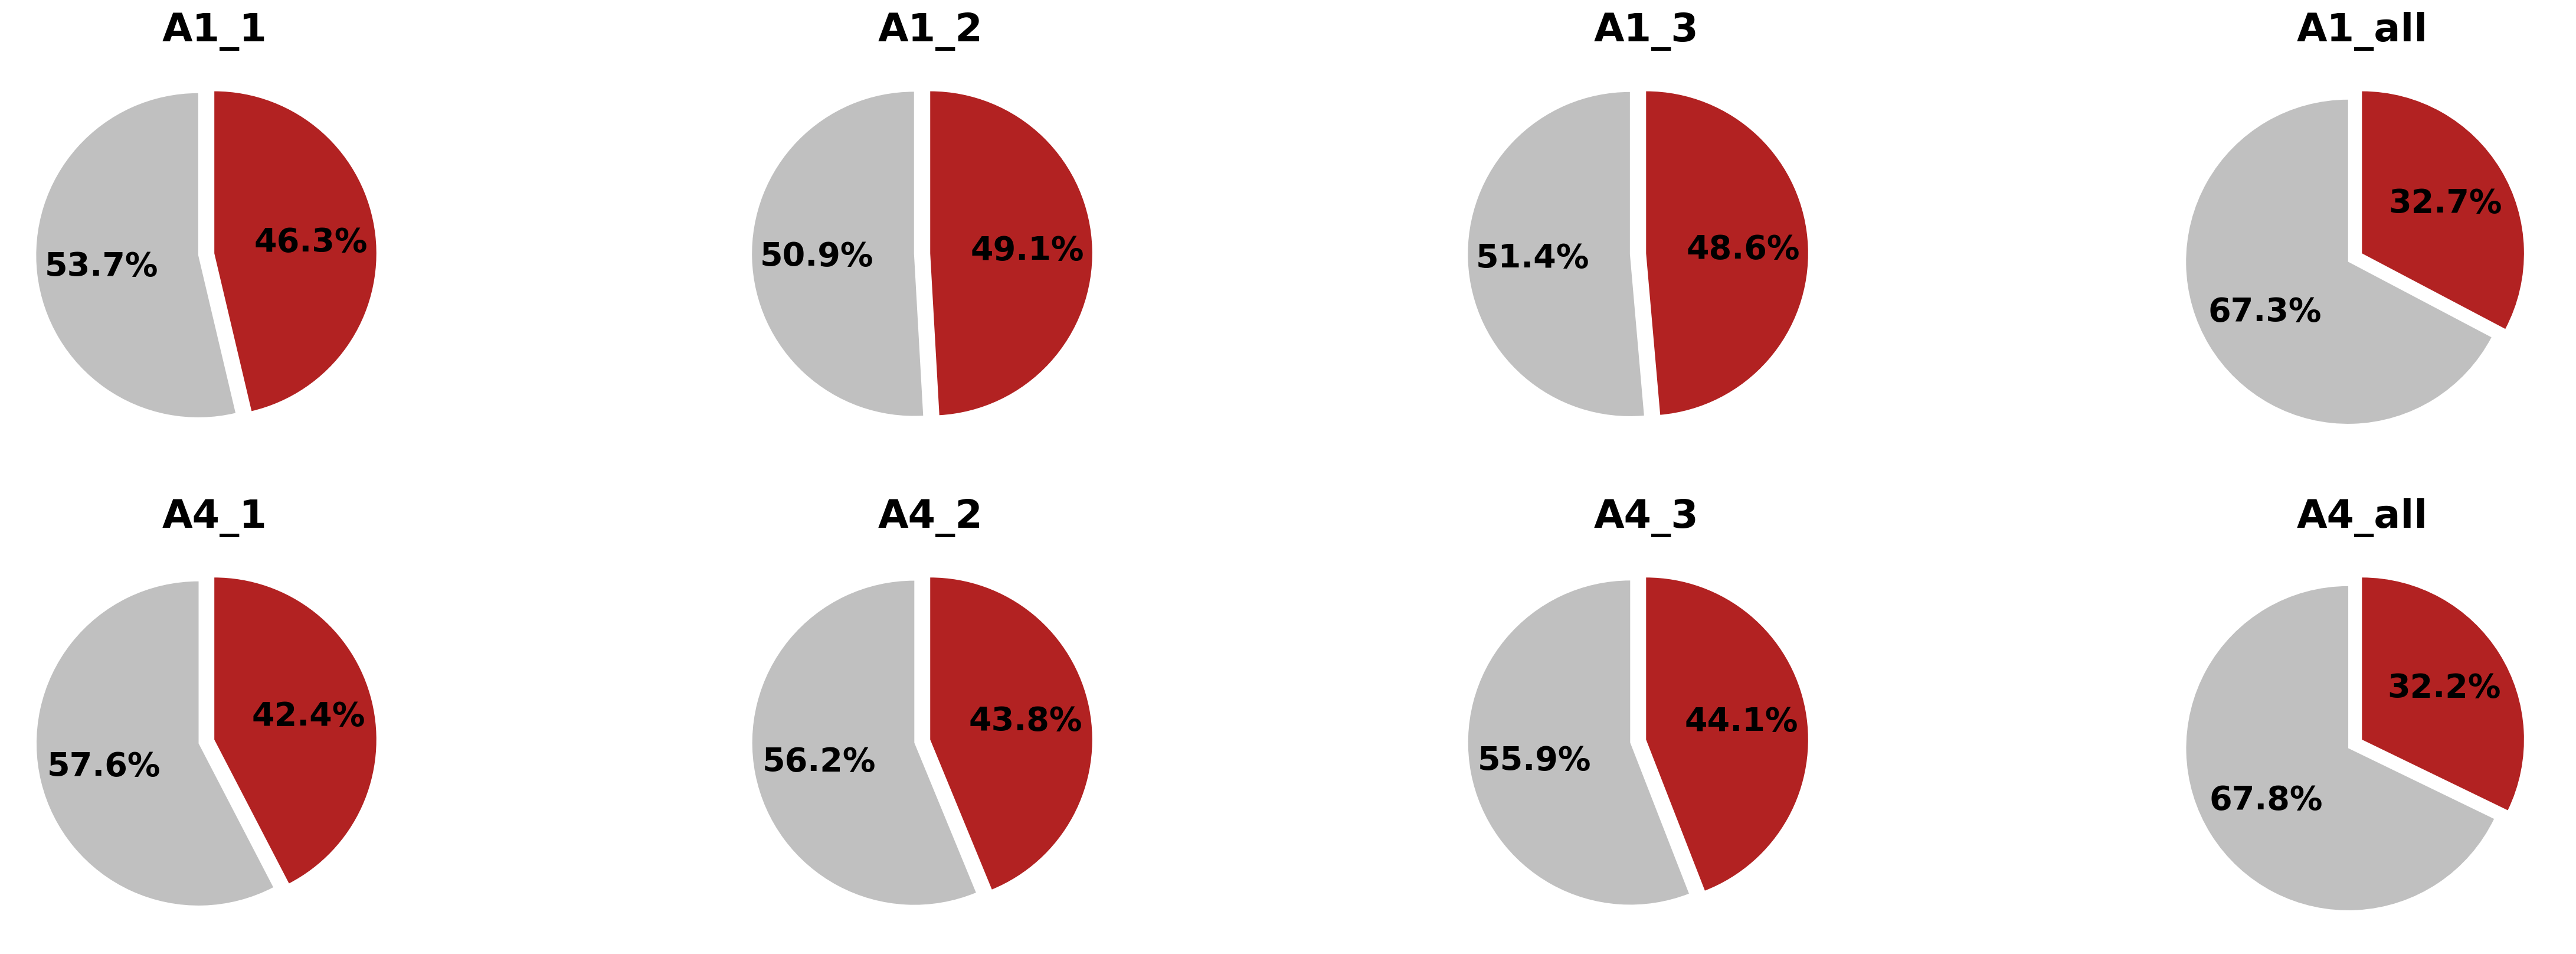

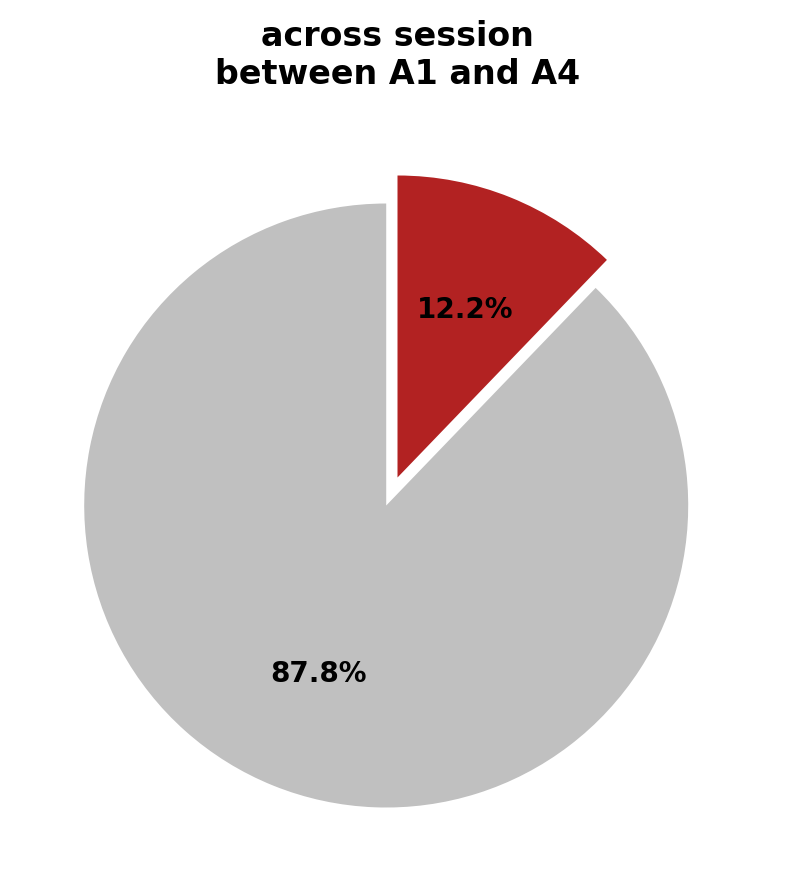

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 10))
row_number = -1
means = df_1sd.mean()
for i, context_name in enumerate(means.index[:-1]):
    index = i % 4
    if index == 0:
        row_number += 1
    
    shock_rate = means[context_name]
    non_shock_rate = 1.0 - shock_rate
    ax = axes[row_number][index]
    ax.pie([non_shock_rate, shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold', 'size': 20},
            colors=['silver', 'firebrick']
                               )
    ax.set_title(context_name, fontsize=24, fontweight='bold')
    
fig.show()

fig, ax = plt.subplots(dpi=200, figsize=(5, 5))
across_shock_rate = means['across_all']
across_non_shock_rate = 1.0 - across_shock_rate
ax.pie([across_non_shock_rate, across_shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold'},
            colors=['silver', 'firebrick']
      )
ax.set_title('across session\nbetween A1 and A4', fontweight='bold')
fig.show()

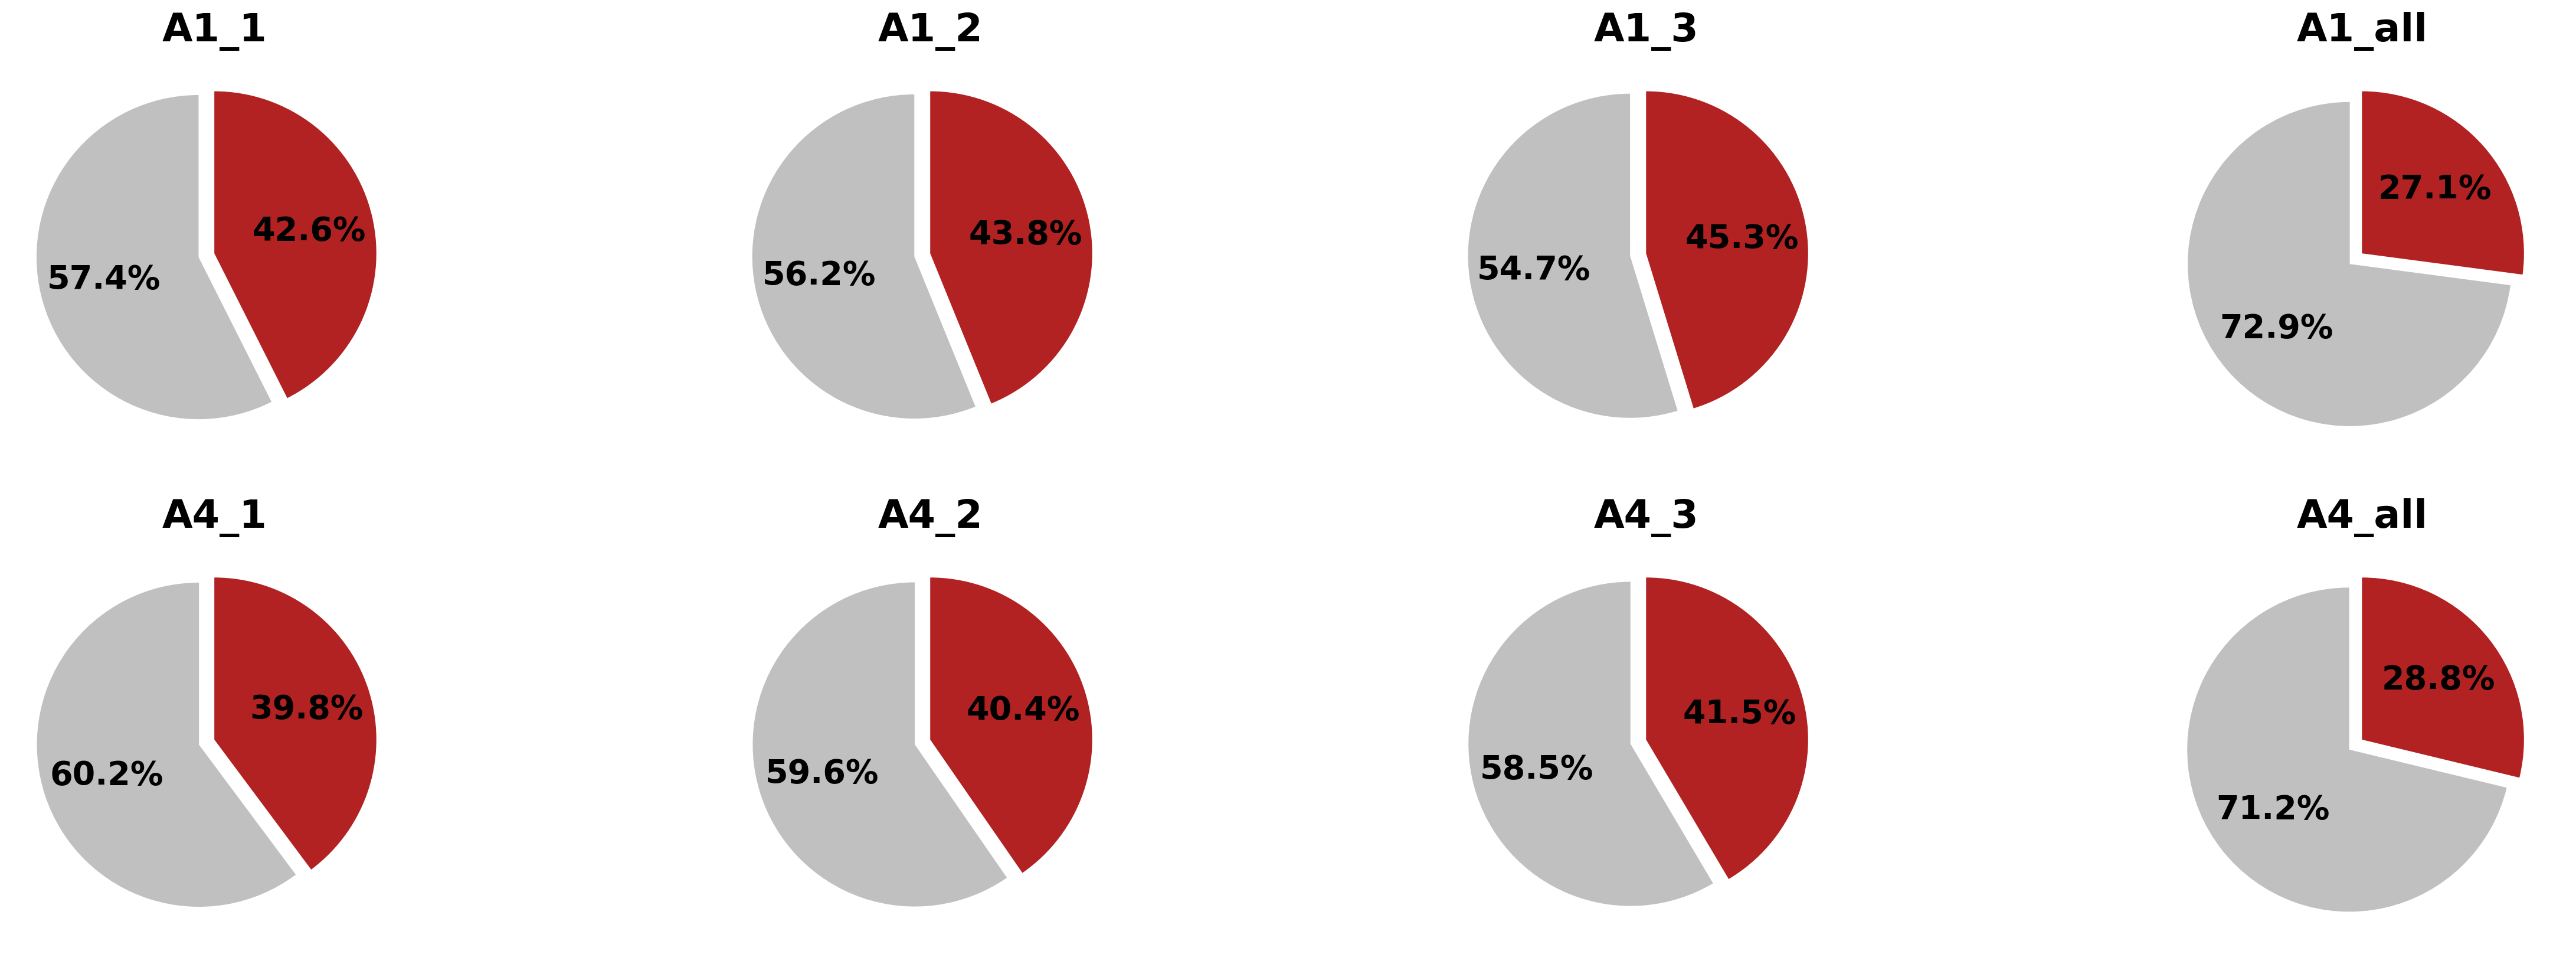

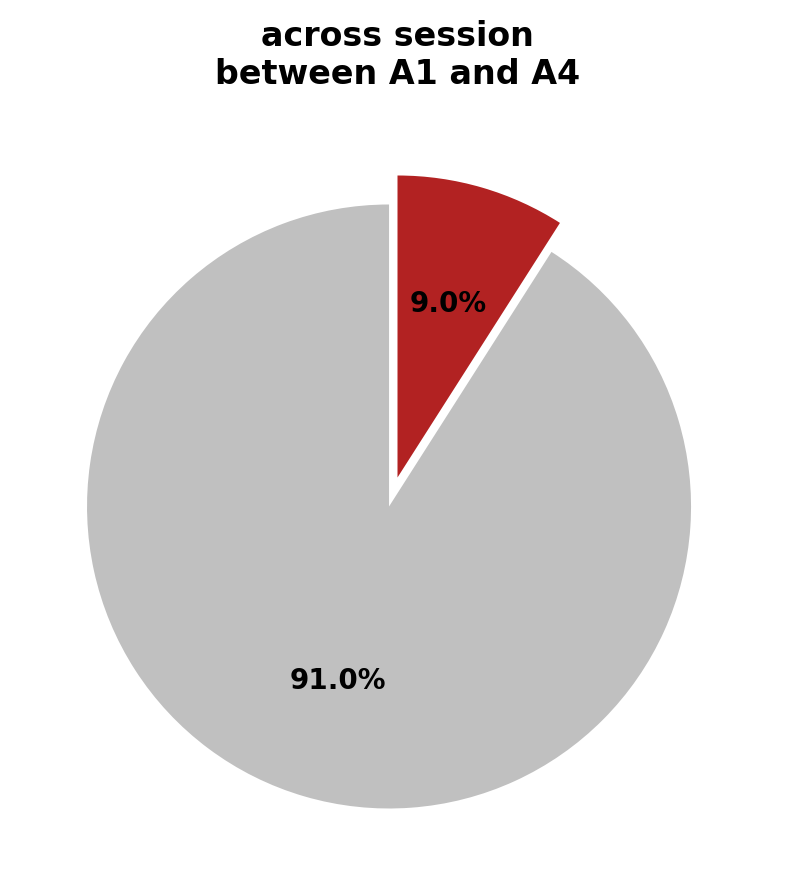

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 10))
row_number = -1
means = df_2sd.mean()
for i, context_name in enumerate(means.index[:-1]):
    index = i % 4
    if index == 0:
        row_number += 1
    
    shock_rate = means[context_name]
    non_shock_rate = 1.0 - shock_rate
    ax = axes[row_number][index]
    ax.pie([non_shock_rate, shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold', 'size': 20},
            colors=['silver', 'firebrick']
                               )
    ax.set_title(context_name, fontsize=24, fontweight='bold')
    
fig.show()

fig, ax = plt.subplots(dpi=200, figsize=(5, 5))
across_shock_rate = means['across_all']
across_non_shock_rate = 1.0 - across_shock_rate
ax.pie([across_non_shock_rate, across_shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold'},
            colors=['silver', 'firebrick']
      )
ax.set_title('across session\nbetween A1 and A4', fontweight='bold')
fig.show()